In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches


#### RANSAC (Random Sample Consensus) Algorithm steps:

1) Sample `s` points from the data
2) Compute model parameters
3) Count number of inliers, i.e. how many points from the dataset fit the model (upto a threshold)
4) Repeat until we find model with largest inlier ratio (number of iterations need to be set appropriately to maximize the probability of finding this best model)


Probabilistic estimate for expected number of iterations need to find good model parameters:

Let $q$ denote probability of selecting an inlier point (i.e. proportion of inlier points in data). Then the probability of slecting `s` points sucessively with all points being inliers is $q^s$. Which means probability of selecting `s` points such that not all points are inliers (i.e. at least 1 outlier point) is $1-q^s$. Then if we draw `N` samples, each containing `s` points, the probability of obtaining N successive contaminated samples (i.e. a sample with not all points being inliers) must be $(1-q^s)^N$. Which means that the probability of all N samples not being contaminated (i.e. at least one sample is purely inliers) must be given by:

$P(\text{at least one pure sample from N draws}) = p = 1-(1-q^s)^N => N = \frac{\log{(1-p)}}{\log{(1-q^s)}}$

This can be used to estimate the expected number of iterations that may be needed to get a good model using RANSAC.

For example, if our inlier ratio is 0.6 and we would like to obtain at least one good sample from N iterations with a probability of 0.99, then the expected number of iterations would be: $N = \frac{\log{(1-0.99)}}{\log{(1-0.6^s)}} = \frac{\log{(0.01)}}{\log{(1-0.6^s)}}$


#### Lets use RANSAC to fit a linear model to 2d data

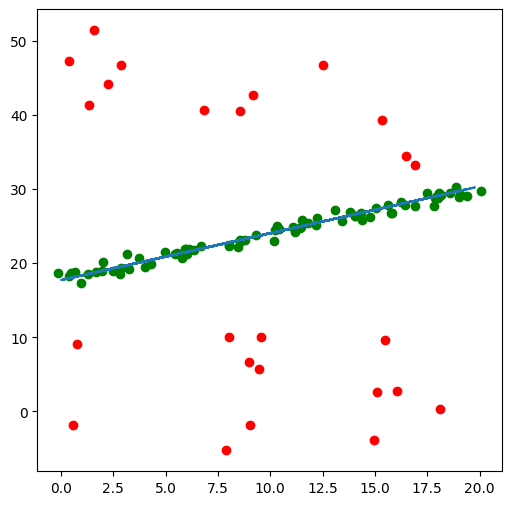

In [3]:
nsamples = 100
outlier_ratio = 0.25

np.random.seed(1)

# first, generate some sample data
x = 20*np.random.random(size=(nsamples))

# generate a random slope and intercept for the line
m = 2.0*np.random.normal()
c = 20*np.random.random()

y = m * x  + c

# now add some gaussian random noise to the data
x_noisy = x + 0.5*np.random.normal(size=x.shape)
y_noisy = y + 0.5*np.random.normal(size=y.shape)

# now add some outliers (i.e. randomly select a subset of points, and replace them with outlier points)
n_outliers = int(nsamples * outlier_ratio)
indices = np.arange(nsamples)
np.random.shuffle(indices)
outlier_indices = indices[0:n_outliers]
inlier_indices =  indices[n_outliers:]

x_noisy[outlier_indices] = 20*np.random.random(size=(n_outliers))
y_noisy[outlier_indices[0:int(n_outliers/2)]] +=  15 + 10*np.random.random(size=(int(n_outliers/2)))
y_noisy[outlier_indices[int(n_outliers/2):]] +=  -15 - 10*np.random.random(size=(n_outliers-int(n_outliers/2)))


# plot the data
plt.figure(figsize=(6,6))
plt.plot(x_noisy[inlier_indices], y_noisy[inlier_indices], marker='o', linestyle='None', color='green', )
plt.plot(x_noisy[outlier_indices], y_noisy[outlier_indices], marker='o', linestyle='None', color='red')
plt.plot(x,y, linestyle='-')
plt.show()



#### Now let's implement the RANSAC loop

In [4]:
# computes perpendicular distance from the line with (slope,intercept) = (m,c) to the point (x0,y0)
def perp_distance(m,c, x0, y0):
    d = np.abs(y0 - (m*x0 + c)) /np.sqrt(1 + m**2)     
    return d


def inlier_rat(data, model_params, threshold):
    # loop over every data point
    inlier_count = 0
    x_inliers = []
    y_inliers = []
    for i in range(len(data)):
        x, y = data[i,0], data[i,1] 
        # compute perpendicular distance from line
        d = perp_distance(model_params[0], model_params[1], x, y)
        # check if inlier (i.e. distance within threshold)
        if(d < threshold):
            inlier_count += 1
            x_inliers.append(x)
            y_inliers.append(y)

    ratio = inlier_count/len(data)
    
    return ratio, x_inliers, y_inliers

def plot_ransac(iteration, x, y, x_inliers, y_inliers, sample_points, model_params):
    
    plt.figure(figsize=(6,6))
    plt.plot(x, y, marker='o', linestyle='None', color='red', alpha=0.25, label='input data')
    plt.plot(x_inliers, y_inliers, marker='o', linestyle='None', color='green', alpha=0.85, label='inliers')
    x_sample = sample_points[:,0]
    y_sample = sample_points[:,1]
    y_model = model_params[0] * x + model_params[1]
    plt.plot(x_sample,y_sample, marker='o', linestyle='None', alpha = 0.9, label='sampled points')
    plt.plot(x, y_model, linestyle='-', color='blue', linewidth=0.1, label='line model')
    plt.legend()
    plt.title('Iteration #' + str(iteration))
    plt.show()


def RANSAC(x, y, num_iters=1, threshold=2.0):

    data = np.array(list(zip(x,y)))
    best_ratio = 0.0
    best_model_params = None

    for i in range(num_iters):

        # select two points uniformly at random
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        indices_sample = indices[:2]
        indices_other = indices[2:]
        sample = data[indices_sample]

        # compute model parameters
        slope = (sample[1,1] - sample[0,1])/ (sample[1,0] - sample[0,0])
        intercept = sample[1,1] - slope * sample[1,0]
        model_params = (slope, intercept)

        # compute inlier ratio (exlude the sample points)
        inlier_ratio, x_inliers, y_inliers = inlier_rat(data[indices_other], model_params, threshold) 

        # save best model
        if(inlier_ratio > best_ratio):
            best_ratio = inlier_ratio
            best_model_params = model_params
            print(f"Iteration# {i}, Found better inlier ratio: {best_ratio}, model_params: {best_model_params}")

            plot_ransac(i, x, y, x_inliers, y_inliers, sample, best_model_params)

            


Iteration# 0, Found better inlier ratio: 0.5408163265306123, model_params: (0.3874910996430655, 19.24881998593383)


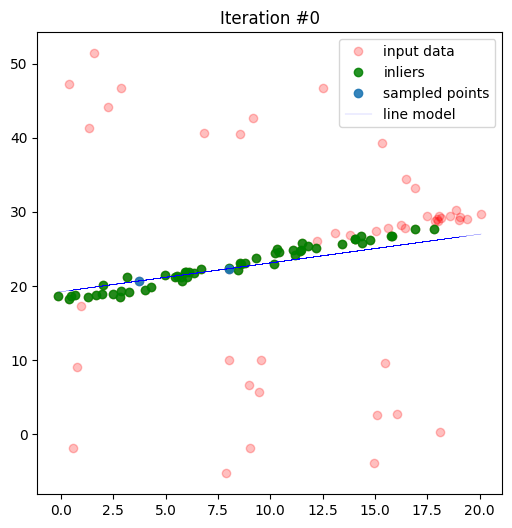

Iteration# 2, Found better inlier ratio: 0.6938775510204082, model_params: (0.5017560374132232, 19.985204231688382)


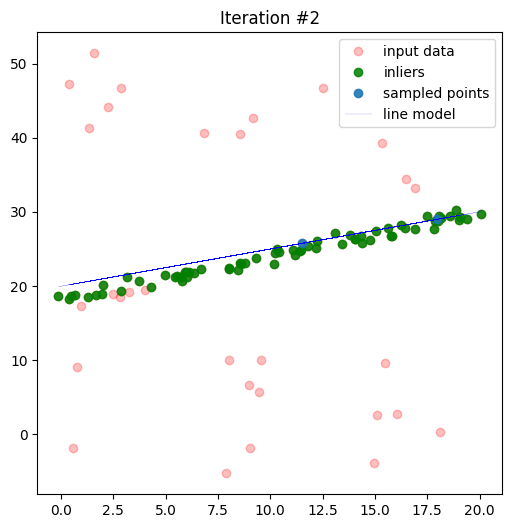

Iteration# 7, Found better inlier ratio: 0.7448979591836735, model_params: (0.5476066981916466, 18.652811081454697)


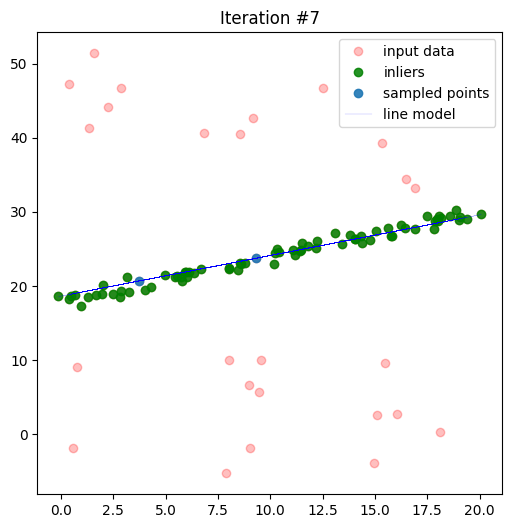

In [5]:
# estimated number of iterations needed to find pure inlier sample with 99% probability
Niters = 10*int(np.ceil(np.log(0.01)/ np.log(1-(1-outlier_ratio)**2))) 

RANSAC(x_noisy, y_noisy, Niters)

#### Now let's implement a RANSAC circle detector. Need 3 parameters to fit a circle, the radius and ceter co-ordinates.

(-0.5, 507.5, 338.5, -0.5)

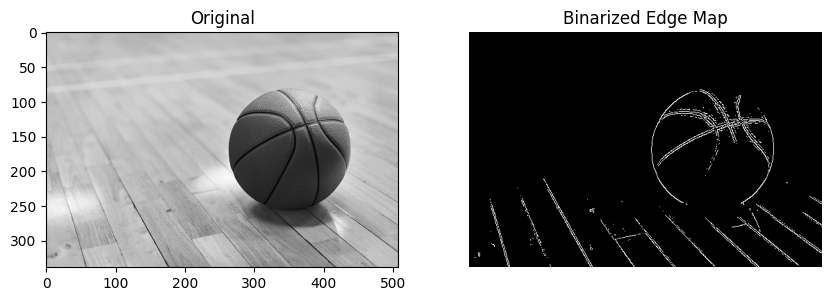

In [6]:
# load test image and get an edge map
img = cv2.imread("./test_images/basketball.jpg", cv2.IMREAD_GRAYSCALE)


img_edge = cv2.Canny(img, threshold1=210, threshold2=220, L2gradient=False, apertureSize=3)


# remove uniform regions from the edge map
'''kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(img_edge, kernel, iterations=5)
eroded = cv2.erode(dilated, kernel, iterations=5)
pure_edges = cv2.absdiff(img_edge, eroded)'''


# convert edge map to binary
#img_edge = -img_edge + 255
_, img_binary = cv2.threshold(img_edge, 100, 255, cv2.THRESH_BINARY)
img_binary = img_edge

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original')


plt.subplot(1,2,2)
plt.imshow(img_binary, cmap='gray')
plt.title('Binarized Edge Map')
plt.axis('off')

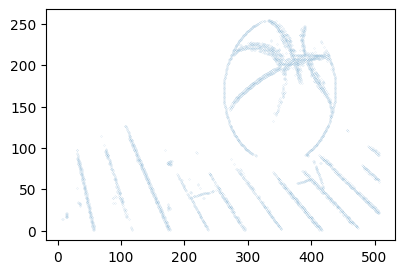

In [7]:
# extract out the edge pixels
row_indices, col_indices = np.nonzero(img_binary)

# convert to (x,y) coordinates
x = col_indices
y = len(img_binary) - row_indices  # y coordinate is the row index flipped upside down

plt.figure(figsize=(4.5,3))
plt.plot(x,y, marker='.', markersize=0.1, linestyle='None')
plt.show()

#### Implementing RANSAC for circle model. 

Circle model requires three points to compute the parameters (a,b,r):

$(x_i-a)^2 + (y_i-b)^2 = r^2$

$i=1,2,3$

Let A, B, C denote three points lying on a cirlce. Then let AB and BC be line segments connecting A,B and B,C respectively. Then the perpendicular bisector of segment AB necessarily passes through the circle center. We can easily find the equation of this perpendicular bisector: $y = m_{AB} x  + c_{AB}$. Similarly, the perpendicular bisector of segment BC, with equation $y = m_{BC} x  + c_{BC}$, also passes through the circle center. Then the interesction of these two perpendicular bisectors given us circle center $(a,b)$:

$m_{AB} * a + C_{AB} = m_{BC} * a + C_{BC} => a = \frac{C_{BC}-C_{AB}}{(m_{AB}-m_{BC})}$

$b = m_{AB} * a + C_{AB}$

Then we can compute the circle radius using any one of the 3 points and the circle center:

$r = \sqrt{(x_1 - a)^2 + (y_1-b)^2}$


In [8]:
def compute_model_params_circle(points):
    p1 = points[0]
    p2 = points[1]
    p3 = points[2]
    # compute midpoint of segment connecting p1, p2 (segment AB)
    mid_x1 = 0.5*(p1[0] + p2[0])
    mid_y1 = 0.5*(p1[1] + p2[1])
    # compute midpoint of segment connecting p2, p3 (segment BC)
    mid_x2 = 0.5*(p2[0] + p3[0])
    mid_y2 = 0.5*(p2[1] + p3[1])

    # compute slopes of segments AB and BC
    slope_ab = (p2[1] - p1[1]) / (p2[0] - p1[0])
    slope_bc = (p3[1] - p2[1]) / (p3[0] - p2[0])
    
    # compute slopes of perpendicular bisectors
    m_ab = -1.0 / slope_ab
    m_bc = -1.0 / slope_bc

    # compute y-intercepts of the bisectors
    c_ab = mid_y1 - m_ab * mid_x1
    c_bc = mid_y2 - m_bc * mid_x2

    # find the intersection point of the two bisectors
    a = (c_bc - c_ab) / (m_ab - m_bc)
    b = m_ab * a + c_ab

    # compute radius
    r = np.sqrt((p1[0]-a)**2 + (p1[1]-b)**2) 

    return (a,b,r)


# computes distance from the circle center (a,b) to the point (x0,y0)
def perp_distance_circle(a, b, x0, y0):
    d = np.sqrt((x0-a)**2 + (y0-b)**2)     
    return d


def inlier_rat_circle(data, model_params, threshold):
    # loop over every data point
    inlier_count = 0
    x_inliers = []
    y_inliers = []
    for i in range(len(data)):
        x, y = data[i,0], data[i,1] 
        # compute distance from circle center
        d = perp_distance_circle(model_params[0], model_params[1], x, y)
        # check if inlier (i.e. distance in range [r-threshold, r+threshold])
        if(d > model_params[2]-threshold) and (d < model_params[2]+threshold):
            inlier_count += 1
            x_inliers.append(x)
            y_inliers.append(y)

    ratio = inlier_count/len(data)
    
    return ratio, x_inliers, y_inliers

def plot_ransac_circle(iteration, x, y, x_inliers, y_inliers, sample_points, model_params):
    
    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker='o', linestyle='None', color='red', alpha=0.25, label='input data')
    plt.plot(x_inliers, y_inliers, marker='o', linestyle='None', color='green', alpha=0.85, label='inliers')
    x_sample = sample_points[:,0]
    y_sample = sample_points[:,1]
    plt.plot(x_sample,y_sample, marker='o', linestyle='None', alpha = 0.9, label='sampled points')
    # model
    circle = patches.Circle((model_params[0], model_params[1]), radius=model_params[2], edgecolor='blue', facecolor='none')
    plt.gca().add_patch(circle)
    
    plt.legend()
    plt.title('Iteration #' + str(iteration))
    plt.show()


def RANSAC_circle(x, y, num_iters=1, threshold=3.0):

    data = np.array(list(zip(x,y)))
    best_ratio = 0.0
    best_model_params = None

    for i in range(num_iters):

        # select three points uniformly at random
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        indices_sample = indices[:3]
        indices_other = indices[3:]
        sample_points = data[indices_sample]

        # compute model parameters
        a,b,r = compute_model_params_circle(sample_points)
        model_params = (a,b,r)

        # compute inlier ratio (exlude the sample points)
        inlier_ratio, x_inliers, y_inliers = inlier_rat_circle(data[indices_other], model_params, threshold) 

        # save best model
        if(inlier_ratio > best_ratio):
            best_ratio = inlier_ratio
            best_model_params = model_params
            print(f"Iteration# {i}, Found better inlier ratio: {best_ratio}, model_params: {best_model_params}")

            plot_ransac_circle(i, x, y, x_inliers, y_inliers, sample_points, best_model_params)

            


Iteration# 0, Found better inlier ratio: 0.04934021801491681, model_params: (403.4626604434073, -79.60618436406071, 280.6593511046393)


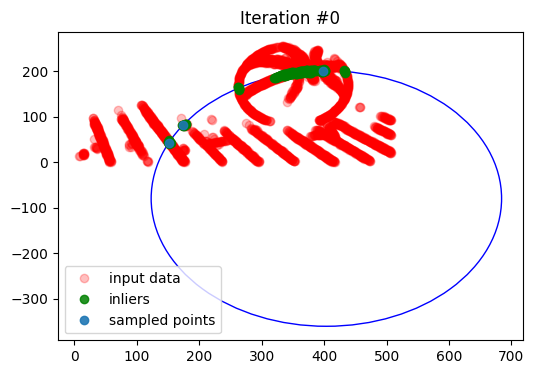

Iteration# 3, Found better inlier ratio: 0.05966724039013196, model_params: (348.5307414104883, 134.5488245931284, 96.98174117285483)


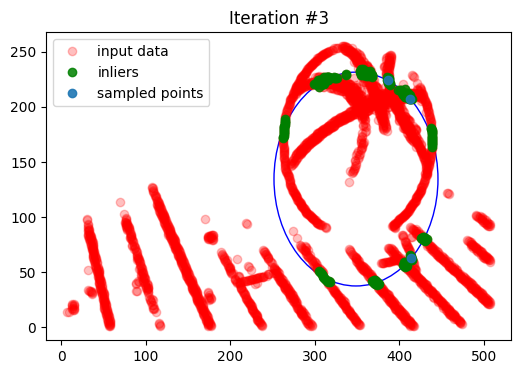

Iteration# 7, Found better inlier ratio: 0.06884681583476764, model_params: (373.0, 115.257225433526, 86.8349522916327)


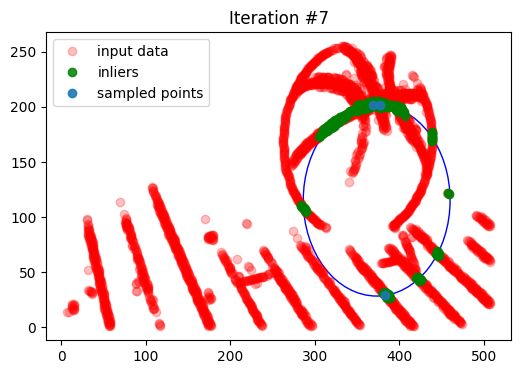

Iteration# 10, Found better inlier ratio: 0.07687894434882386, model_params: (342.1418753530409, 108.92816795330444, 104.11924705014754)


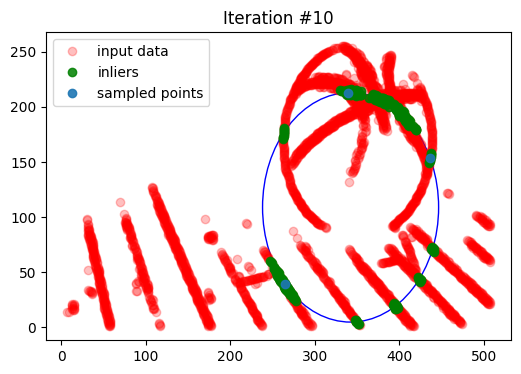

Iteration# 17, Found better inlier ratio: 0.0963855421686747, model_params: (310.47707032449586, 64.33058654928936, 156.29410144838863)


/tmp/ipykernel_251356/2610381013.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  m_bc = -1.0 / slope_bc
/tmp/ipykernel_251356/2610381013.py:25: RuntimeWarning: invalid value encountered in double_scalars
  a = (c_bc - c_ab) / (m_ab - m_bc)


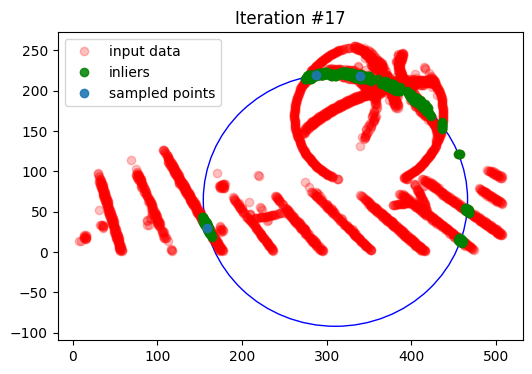

/tmp/ipykernel_251356/2610381013.py:14: RuntimeWarning: divide by zero encountered in long_scalars
  slope_bc = (p3[1] - p2[1]) / (p3[0] - p2[0])


Iteration# 189, Found better inlier ratio: 0.10413080895008606, model_params: (311.53591160221, 89.62154696132598, 133.65418615842765)


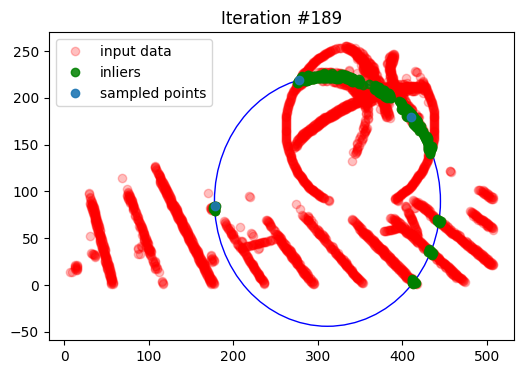

/tmp/ipykernel_251356/2610381013.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  m_ab = -1.0 / slope_ab


Iteration# 453, Found better inlier ratio: 0.10814687320711418, model_params: (349.66523702031606, 166.25039503386006, 85.41804740578124)


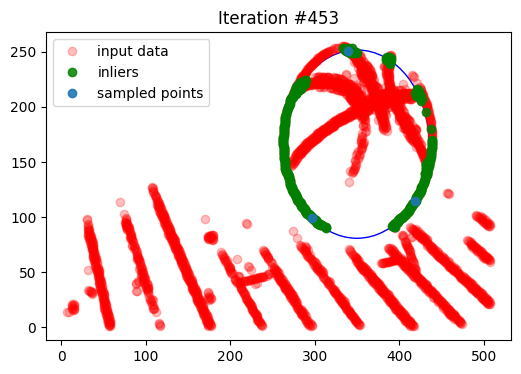

Iteration# 537, Found better inlier ratio: 0.12335054503729202, model_params: (316.9425332290852, 100.37646598905394, 124.07272165838715)


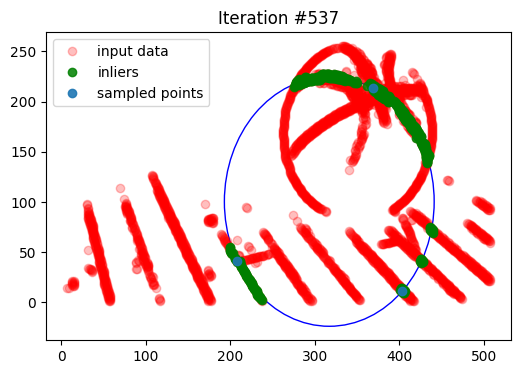

/tmp/ipykernel_251356/2610381013.py:13: RuntimeWarning: divide by zero encountered in long_scalars
  slope_ab = (p2[1] - p1[1]) / (p2[0] - p1[0])


Iteration# 1316, Found better inlier ratio: 0.1333907056798623, model_params: (349.4288678126853, 169.04831061055128, 87.56314420116011)


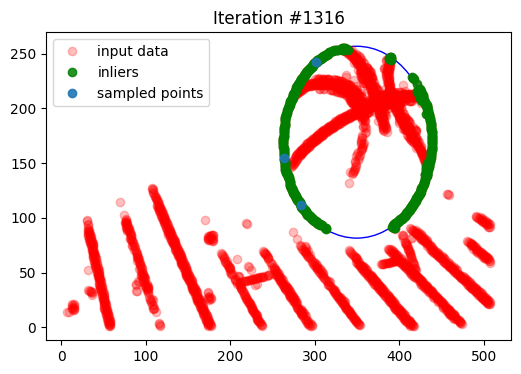

In [9]:
RANSAC_circle(x, y, 2000)